In [1]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely.geometry import MultiLineString, Point, MultiPoint
import json
import folium
from shapely.ops import nearest_points



In [37]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely.geometry import MultiLineString, Point, MultiPoint
import json
import folium
from shapely.ops import nearest_points



In [38]:
df = pd.read_csv(file_path)

In [39]:
def renameColumns(df):
    df.rename(columns={'timestamp': 'Time', 'placa': 'Plate', 'ruta': 'Route', 'latitud': 'Latitude', 'longitud': 'Longitude'}, inplace=True)
    return df

def filter_and_format_df(df, route, initialScale):
    filtered_df = df.copy()
    filtered_df = renameColumns(filtered_df)
    # Convert 'Time' to datetime
    filtered_df['Time'] = pd.to_datetime(filtered_df['Time'])
    # Filter DataFrame to match conditions
    filtered_df = filtered_df[(filtered_df['Route'] == route) ]#&
                              #(filtered_df['Plate'] == plate) &
                              #(filtered_df['Time'] >= pd.to_datetime(receivedStartTime)) &
                              #(filtered_df['Time'] <= pd.to_datetime(receivedEndTime))]
    # Reset the index of filtered_df to ensure sequential indexing after filtering
    filtered_df.reset_index(drop=True, inplace=True)
    # Set scale (useful when plotting in folium)
    filtered_df['Scale'] = initialScale
    return filtered_df

In [40]:
empiric_df = filter_and_format_df(df, route, 2)
empiric_df

,Time,Plate,Route,Latitude,Longitude,velocidad,contadorpasajeros,tipounidad,Scale
0,2023-02-27 00:00:06,50050,RUTA 5,19.385832,-99.226166,0,0,AUTOBUS CORTO (ENTRE 7.5 Y 10 M DE LONGITUD),2
1,2023-02-27 00:00:43,50116,RUTA 5,19.385124,-99.198440,0,0,AUTOBUS CORTO (ENTRE 7.5 Y 10 M DE LONGITUD),2
2,2023-02-27 00:00:45,50050,RUTA 5,19.385832,-99.226166,0,0,AUTOBUS CORTO (ENTRE 7.5 Y 10 M DE LONGITUD),2
3,2023-02-27 00:01:44,50050,RUTA 5,19.385832,-99.226166,0,0,AUTOBUS CORTO (ENTRE 7.5 Y 10 M DE LONGITUD),2
4,2023-02-27 00:01:50,50116,RUTA 5,19.385122,-99.198440,0,0,AUTOBUS CORTO (ENTRE 7.5 Y 10 M DE LONGITUD),2
...,...,...,...,...,...,...,...,...,...
74709,2023-03-05 23:59:39,50336,RUTA 5,19.342667,-99.279760,0,0,VAGONETA,2
74710,2023-03-05 23:59:39,50162,RUTA 5,19.342611,-99.287440,0,0,AUTOBUS CORTO (ENTRE 7.5 Y 10 M DE LONGITUD),2
74711,2023-03-05 23:59:40,50242,RUTA 5,19.380463,-99.250160,0,0,AUTOBUS CORTO (ENTRE 7.5 Y 10 M DE LONGITUD),2
74712,2023-03-05 23:59:47,50116,RUTA 5,19.385002,-99.198310,0,0,AUTOBUS CORTO (ENTRE 7.5 Y 10 M DE LONGITUD),2


In [41]:
# Display points
def plot_points(df, map, with_info=True):
    # Plot each point with a circle marker
    for index, row in df.iterrows():
        if with_info: 
            tooltip = f"Coord: ({row['Latitude']}, {row['Longitude']}), Time: {row['Time']}, Index: {index}"
            scale = row['Scale']
        else: 
            tooltip = ''
            scale = 2
        folium.CircleMarker(
            location=(row['Latitude'], row['Longitude']),
            radius=scale,  
            tooltip=tooltip,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.5
        ).add_to(map)

def map_points(df, with_info=True):
    # Create a map
    m = folium.Map(location=[df.iloc[0]['Latitude'], df.iloc[0]['Longitude']], zoom_start=13)
    # Plot each point with a circle marker
    plot_points(df, m, with_info)
    # m.save(file_name)
    return m

# Given a df wiht Latitude and Longitude columns, it gives back the predicted variant of the route that it represents
def classify_route_variant(df, route_df):
    if len(df['Route'].unique()) > 1:
        print("Invalid dataframe, it contains information on more than one route")
        return None
    else:
        # Convert filtered_df to a GeoDataFrame with Point geometries
        gdf_points = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df.Longitude, df.Latitude)], crs="EPSG:4326")
        # Ensure route_df is correctly set as a GeoDataFrame and has the correct CRS
        if not route_df.crs:
            route_df = route_df.set_crs("EPSG:4326")
        # Initialize a dictionary to store the sum of distances for each route variant and the nearest points
        total_distances = {}
        # Calculate distance from each route variant to all points and sum these distances
        for route_index, route_row in route_df.iterrows():
            total_distance = 0
            # Sum distances from this route variant to each point
            for _, row in gdf_points.iterrows():
                distance = route_row.geometry.distance(row.geometry)
                total_distance += distance
            # Store the total distance for this route variant
            total_distances[route_index] = total_distance
        # Determine the route variant with the minimum total distance to all points
        closest_route_index = min(total_distances, key=total_distances.get)

        return route_df.loc[closest_route_index], total_distances[closest_route_index] # Route variant and the deviation measure
    
def plot_nearest_points(filtered_df, closest_route_variant, m):
    # Convert filtered_df to a GeoDataFrame with Point geometries
    gdf_points = gpd.GeoDataFrame(filtered_df, geometry=[Point(xy) for xy in zip(filtered_df.Longitude, filtered_df.Latitude)], crs="EPSG:4326")
    # Extract the coordinates of the nearest points
    for _, point_row in gdf_points.iterrows():
        # Find the nearest points on both geometries
        nearest_geom = nearest_points(point_row.geometry, closest_route_variant.geometry)
        point_coords = (nearest_geom[0].y, nearest_geom[0].x)
        nearest_point_coords = (nearest_geom[1].y, nearest_geom[1].x)
        # Create a green line between the point and the nearest point on the route
        folium.PolyLine([point_coords, nearest_point_coords], color='green').add_to(m)
    
def comparing_map(filtered_df, closest_route_variant):
    # Initialize a folium map
    # Use the first point from filtered_df as the center for the folium map
    map_center = [filtered_df.iloc[0]['Latitude'], filtered_df.iloc[0]['Longitude']]
    m = folium.Map(location=map_center, zoom_start=14)
    for point in closest_route_variant.geometry.geoms:
        folium.CircleMarker(
            location=(point.y, point.x),  # Convert (lon, lat) to (lat, lon)
            radius=3,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.3,
            popup='Route Variant Point'
        ).add_to(m)
    # Plot points from filtered_df
    for _, row in filtered_df.iterrows():
        tooltip = f"Coord: ({row['Latitude']}, {row['Longitude']}), Time: {row['Time']}"
        folium.CircleMarker(
            location=(row['Latitude'], row['Longitude']),
            radius=3,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            popup='Filtered_df Point',
            tooltip=tooltip
        ).add_to(m)
    plot_nearest_points(filtered_df, closest_route_variant, m)
    # Save and return the map
    #m.save(file_name)
    return m

In [7]:
# Get the nodes and edges of the city
place_name = "Mexico City, Mexico"
G = ox.graph_from_place(place_name, network_type='drive')


In [42]:
# Get official variants from the pdf files
def openJSONfile(file_path):
    with open(file_path, 'r', encoding="utf-8") as file:
        return json.load(file)    
official_route_5 = openJSONfile('Data/ruta_5.json')


# Transform json info into a pandas gdf
rows = []
for branch, directions in official_route_5.items():
    all_lines = []
    for direction, types in directions.items():
        for line_type in ['confirmada', 'hueco', 'inconfirmada']:
            for segment in types[line_type]:
                points = [(G.nodes[i]['x'], G.nodes[i]['y']) for i in segment]
                all_lines.extend(points)
    geometry = MultiPoint(all_lines)
    rows.append({'Branch': branch, 'geometry': geometry})

# Create GeoDataFrame
official_routes = gpd.GeoDataFrame(rows, columns=['Branch', 'geometry'])

# Display the GeoDataFrame
official_routes

,Branch,geometry
0,1,"MULTIPOINT (-99.18353 19.40940, -99.18395 19.4..."
1,2,"MULTIPOINT (-99.20220 19.39052, -99.20308 19.3..."
2,3,"MULTIPOINT (-99.20220 19.39052, -99.20308 19.3..."
3,4,"MULTIPOINT (-99.20220 19.39052, -99.20308 19.3..."
4,5,"MULTIPOINT (-99.19126 19.39677, -99.19142 19.3..."
5,6,"MULTIPOINT (-99.27596 19.35555, -99.27355 19.3..."
6,7,"MULTIPOINT (-99.19126 19.39677, -99.19142 19.3..."
7,8,"MULTIPOINT (-99.19126 19.39677, -99.19142 19.3..."
8,9,"MULTIPOINT (-99.19126 19.39677, -99.19142 19.3..."
9,10,"MULTIPOINT (-99.19126 19.39677, -99.19142 19.3..."


In [43]:
# Transform json info into a pandas gdf
rows = []
for branch, directions in official_route_5.items():
    for direction, types in directions.items():
        all_lines = []
        for line_type in ['confirmada', 'hueco', 'inconfirmada']:
            for segment in types[line_type]:
                points = [(G.nodes[i]['x'], G.nodes[i]['y']) for i in segment]
                all_lines.extend(points)
        geometry = MultiPoint(all_lines)
        rows.append({'Branch': branch, 'Direction': direction, 'geometry': geometry})
        
# Create GeoDataFrame
directions_gdf = gpd.GeoDataFrame(rows, columns=['Branch', 'Direction', 'geometry'])

directions_gdf

,Branch,Direction,geometry
0,1,Ida,"MULTIPOINT (-99.18353 19.40940, -99.18395 19.4..."
1,1,Vuelta,"MULTIPOINT (-99.27596 19.35555, -99.27355 19.3..."
2,2,Ida,"MULTIPOINT (-99.20220 19.39052, -99.20308 19.3..."
3,2,Vuelta,"MULTIPOINT (-99.22122 19.38731, -99.22070 19.3..."
4,3,Ida,"MULTIPOINT (-99.20220 19.39052, -99.20308 19.3..."
5,3,Vuelta,"MULTIPOINT (-99.27833 19.35174, -99.27776 19.3..."
6,4,Ida,"MULTIPOINT (-99.20220 19.39052, -99.20308 19.3..."
7,4,Vuelta,"MULTIPOINT (-99.27698 19.35789, -99.27730 19.3..."
8,5,Ida,"MULTIPOINT (-99.19126 19.39677, -99.19142 19.3..."
9,5,Vuelta,"MULTIPOINT (-99.28588 19.32986, -99.28642 19.3..."


In [44]:
def group_points(df, precision=4):
    rounded_df = df.copy()
    # Add rounded coordinates directly to the original DataFrame to preserve index
    rounded_df['RoundedLatitude'] = rounded_df['Latitude'].round(precision)
    rounded_df['RoundedLongitude'] = rounded_df['Longitude'].round(precision)
    # Group by rounded coordinates to find the first index of each group and count occurrences
    grouped = rounded_df.groupby(['RoundedLatitude', 'RoundedLongitude'])
    first_index = grouped['Latitude'].transform('idxmin')  # Get the index of the first occurrence
    counts = grouped['Latitude'].transform('size')  # Get counts of each group for the 'Scale' calculation
    # Select rows that are the first occurrence in each group
    unique_df = rounded_df.loc[rounded_df.index.isin(first_index)].copy()
    # Calculate 'Scale' as twice the count of points rounded to that coordinate
    unique_df['Scale'] = unique_df['Scale'] * counts.loc[unique_df.index]
    # Ensure the resulting DataFrame is ordered by the original index (ascending)
    unique_df.sort_index(inplace=True)
    return unique_df

def group_within_intervals(df, precision, time_interval_s):
    frames =[]
    start_index = 0
    while start_index < len(df):
        # Get the limits of the interval
        start_time = df.iloc[start_index]['Time']
        end_time = start_time + pd.Timedelta(seconds=time_interval_s)
        # Subset of points within the current time interval
        time_interval_df = df[(df['Time'] >= start_time) & (df['Time'] <= end_time)].copy()
        if not time_interval_df.empty:
            # Group and concat to join time intervals
            frames.append(group_points(time_interval_df, precision))
            # Update start_index for the next iteration based on the last index found + 1
            last_index_in_interval = time_interval_df.index[-1]
            start_index = last_index_in_interval + 1
        else:
            # If no points found in the interval, increment start_index to try the next point
            start_index += 1
    return pd.concat(frames)


import numpy as np
# Find the closest point in the next check_ahead points
# Helps to lose noise and trash coordinates
def closest_points(df, check_ahead=10):
    latitudes = df['Latitude'].to_numpy()
    longitudes = df['Longitude'].to_numpy()
    closer_coords_indexes = [0] # Starting point
    # Start search
    i = 0
    while i<len(latitudes)-1:
        # Calculate distances to the next few points defined by check_ahead or up to the end of the array
        next_points_range = slice(i+1, min(i+1+check_ahead, len(latitudes)))
        lat_diff = latitudes[next_points_range] - latitudes[i]
        lon_diff = longitudes[next_points_range] - longitudes[i]
        # Calculate the Euclidean distance
        distances = np.sqrt(lat_diff**2 + lon_diff**2)
        # Find the index of the minimum distance
        i_min_relative = np.argmin(distances)
        i_min = i + 1 + i_min_relative  # Adjust index relative to the entire dataset
        i = i_min  # Update the current index
        # Append the new index to the closer coordinates list
        closer_coords_indexes.append(i)
    return df.iloc[closer_coords_indexes]

In [45]:
rounding_precision = 4
closer_threshold = 3
time_diff_threshold = 120


In [46]:
def clean_gps_data(df):
    filtered_df = df.copy()
    filtered_df.reset_index(drop=True, inplace=True)
    # Grouped within intervals
    grouped_df = group_within_intervals(filtered_df, rounding_precision, time_diff_threshold)
    grouped_df['Scale'] = 2
    # Points by closest in the next registered
    closest_df = closest_points(grouped_df, closer_threshold)
    return closest_df



In [47]:
from tqdm import tqdm


In [97]:
# Iterate over each unique plate
for plate in tqdm(empiric_df['Plate'].unique()[:1], desc="Processing plates"):
    plate_df = empiric_df[empiric_df['Plate'] == plate]
    sorted_dates = sorted(plate_df['Time'].dt.date.unique())
    
    # Iterate over each unique date for the current plate
    for day in tqdm(sorted_dates[:1], desc=f"Processing dates for plate {plate}"):
        plate_date_df = plate_df[plate_df['Time'].dt.date == day]
        
        # Clean the data
        clean_df = clean_gps_data(plate_date_df)
        
        # Make the prediction
        predicted_df, deviation = classify_route_variant(clean_df, official_routes)
        print(predicted_df)
        m = comparing_map(clean_df, predicted_df)
m

Processing plates:   0%|          | 0/1 [00:00<?, ?it/s]

Branch                                                      5
geometry    MULTIPOINT (-99.1912561 19.3967688, -99.191415...
Name: 4, dtype: object


Processing plates: 100%|██████████| 1/1 [00:06<00:00,  6.24s/it]


In [48]:
records = []
# Iterate over each unique plate
for plate in tqdm(empiric_df['Plate'].unique(), desc="Processing plates"):
    plate_df = empiric_df[empiric_df['Plate'] == plate]
    sorted_dates = sorted(plate_df['Time'].dt.date.unique())
    
    # Iterate over each unique date for the current plate
    for day in tqdm(sorted_dates, desc=f"Processing dates for plate {plate}"):
        plate_date_df = plate_df[plate_df['Time'].dt.date == day]
        
        # Clean the data
        clean_df = clean_gps_data(plate_date_df)
        
        # Make the prediction
        predicted_df, deviation = classify_route_variant(clean_df, official_routes)
        
        # Calculate mean deviation
        mean_deviation = deviation / clean_df.shape[0]  # deviation/points
        
        # Append the record to the list
        records.append({"Plate": plate, "Date": day, "Deviation": mean_deviation})

# Convert the records list to a DataFrame
deviations_df = pd.DataFrame(records)

# Print the DataFrame
print(deviations_df)
        
        


Processing plates: 100%|██████████| 35/35 [10:39<00:00, 18.27s/it]

     Plate        Date  Deviation
0    50050  2023-02-27   0.001195
1    50050  2023-02-28   0.000594
2    50050  2023-03-01   0.000523
3    50050  2023-03-02   0.000852
4    50050  2023-03-03   0.000860
..     ...         ...        ...
137  50112  2023-03-03   0.000830
138  50112  2023-03-04   0.000643
139  50112  2023-03-05   0.003987
140  50214  2023-03-04   0.000097
141  50254  2023-03-05   0.012458

[142 rows x 3 columns]


In [65]:
import random
from scipy.stats import percentileofscore

In [93]:


# Function to calculate percentile of a given deviation
def calculate_percentile(deviation, deviation_series):
    percentile = percentileofscore(deviation_series, deviation)
    return percentile

random_row = deviations_df.loc[random.randint(0,141)]
random_deviation = random_row['Deviation']

# Example: Calculate percentile for a specific deviation
percentile = calculate_percentile(random_deviation, deviations_df['Deviation'])
print(f"The deviation {random_deviation} is in the {percentile}th percentile.")

The deviation 0.0005011262989571509 is in the 13.380281690140846th percentile.


              Plate   Deviation
count    142.000000  142.000000
mean   50179.859155    0.010642
std       92.208413    0.042518
min    50005.000000    0.000097
25%    50112.750000    0.000644
50%    50173.000000    0.001373
75%    50244.000000    0.003977
max    50336.000000    0.231732
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Plate      142 non-null    int64  
 1   Date       142 non-null    object 
 2   Deviation  142 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.5+ KB
None
50050    7
50157    7
50173    7
50116    7
50134    7
50244    6
50199    6
50234    6
50189    5
50311    5
50083    5
50336    4
50060    4
50111    4
50333    4
50288    4
50259    4
50242    4
50005    4
50162    4
50035    4
50302    4
50276    3
50239    3
50115    3
50210    3
50075    3
50112    3
50010    2
50170    2
50285    2


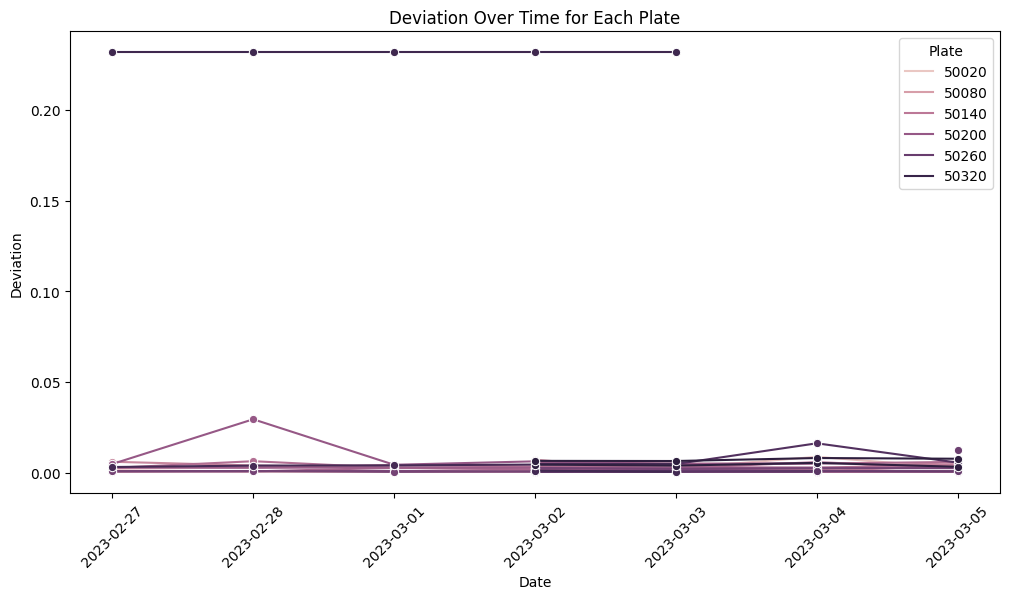

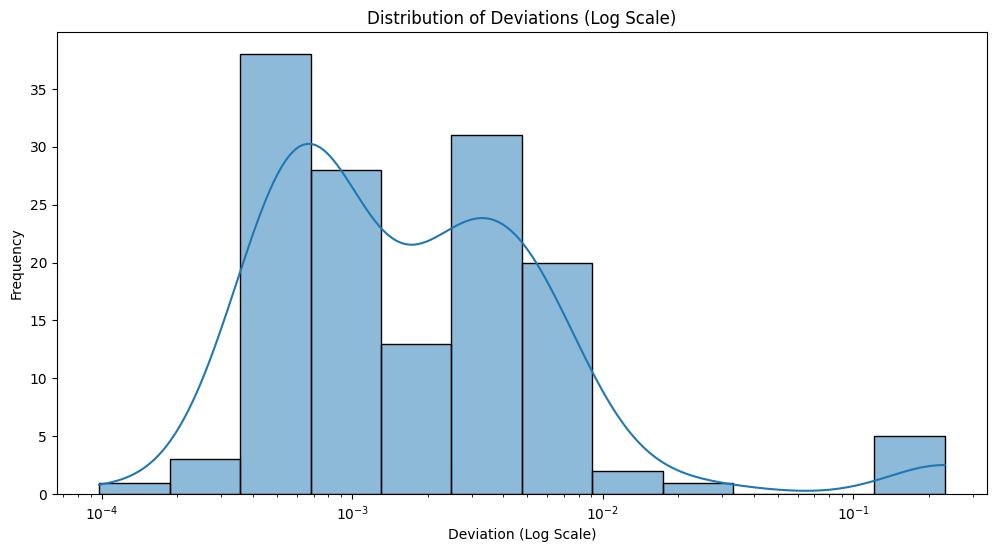

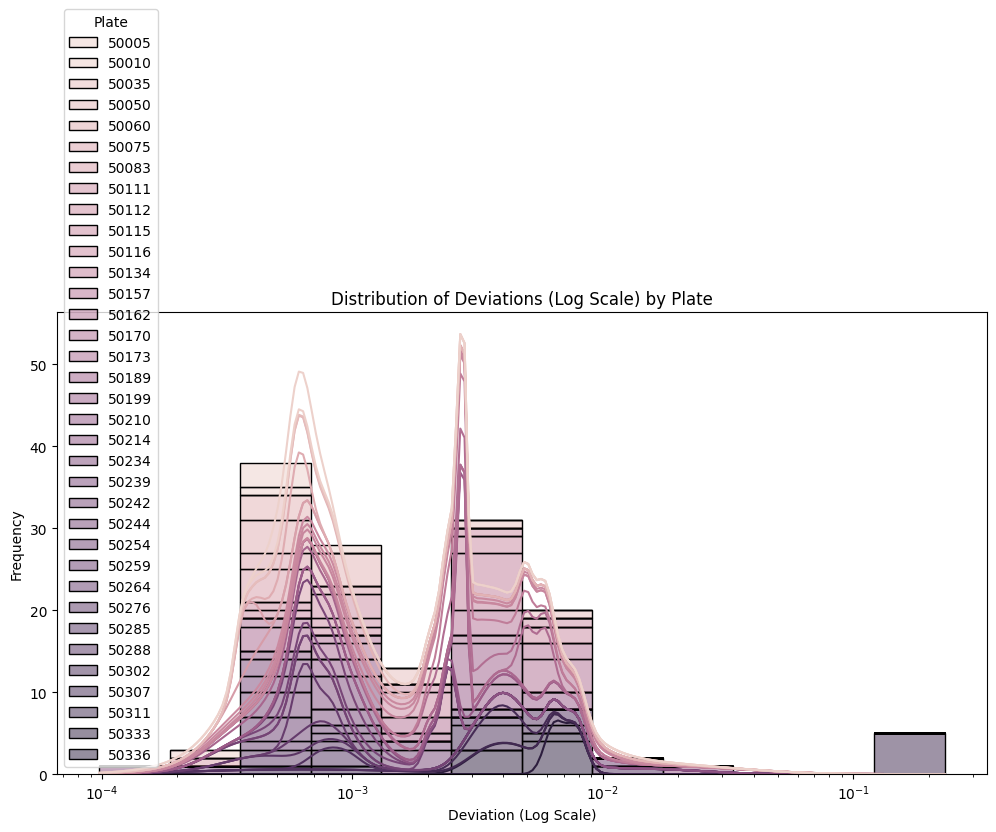

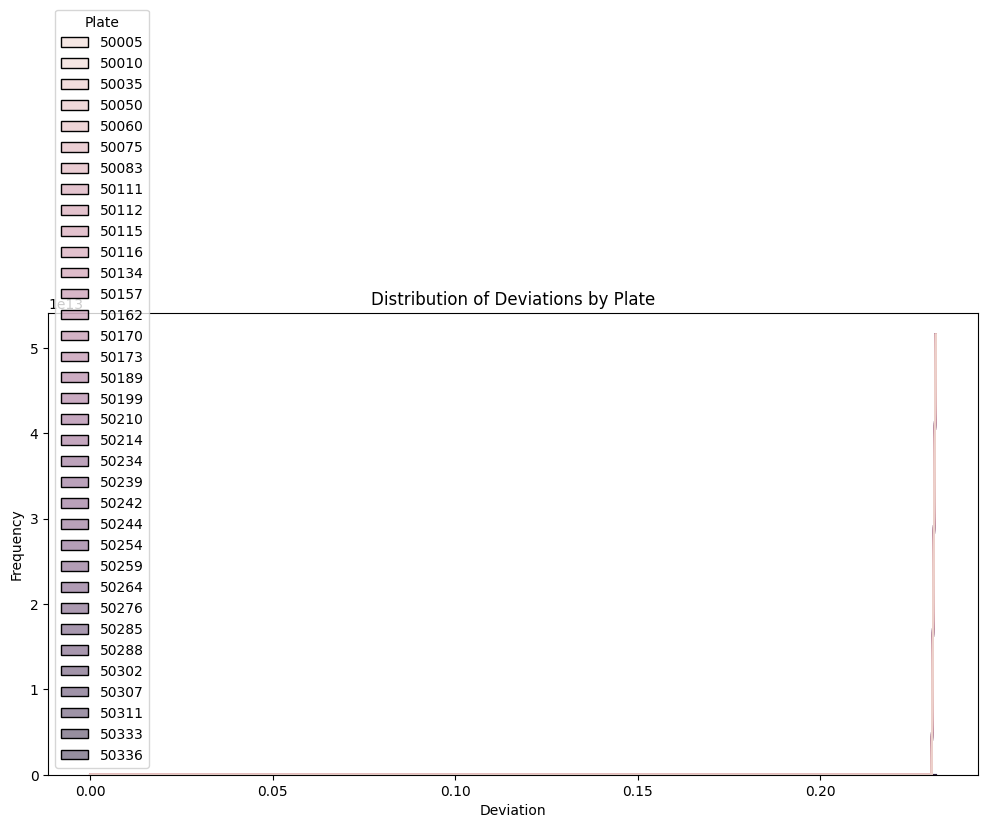

    Plate      mean           std
0   50005  0.000601  9.637961e-05
1   50010  0.000413  2.035251e-04
2   50035  0.003836  3.221018e-03
3   50050  0.000750  2.447267e-04
4   50060  0.000559  6.059694e-05
5   50075  0.000382  3.084119e-05
6   50083  0.000491  1.352197e-04
7   50111  0.002409  3.121989e-03
8   50112  0.001820  1.879318e-03
9   50115  0.001014  4.423998e-04
10  50116  0.003362  1.937311e-03
11  50134  0.003284  8.290708e-04
12  50157  0.003522  1.691331e-03
13  50162  0.005378  4.925406e-04
14  50170  0.000571  2.312624e-04
15  50173  0.001052  8.069752e-04
16  50189  0.002733  9.102629e-05
17  50199  0.009017  9.992528e-03
18  50210  0.000887  2.180189e-04
19  50214  0.000097           NaN
20  50234  0.000774  2.007361e-04
21  50239  0.000849  3.955154e-04
22  50242  0.002335  1.952836e-04
23  50244  0.000581  2.043611e-04
24  50254  0.012458           NaN
25  50259  0.000681  8.849237e-05
26  50264  0.000683  1.114879e-04
27  50276  0.000557  2.267041e-04
28  50285  0.0

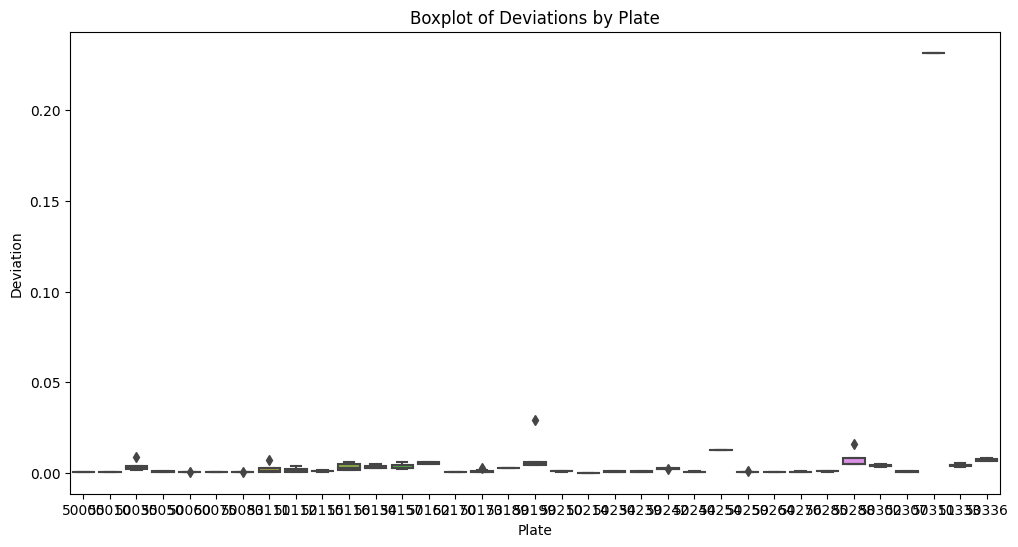

In [57]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

df = deviations_df#[deviations_df['Plate']==50050]

# Data description
print(df.describe())
print(df.info())
print(df['Plate'].value_counts())
print(df['Date'].value_counts())

# Deviation Over Time for Each Plate
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Deviation', hue='Plate', marker='o')
plt.title('Deviation Over Time for Each Plate')
plt.xlabel('Date')
plt.ylabel('Deviation')
plt.xticks(rotation=45)
plt.legend(title='Plate')
plt.show()

# Distribution of Deviations
# Log Scale Histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Deviation', kde=True, log_scale=(True, False))
plt.title('Distribution of Deviations (Log Scale)')
plt.xlabel('Deviation (Log Scale)')
plt.ylabel('Frequency')
plt.show()

# Log Scale Histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Deviation', hue='Plate', kde=True, multiple='stack', log_scale=(True, False))
plt.title('Distribution of Deviations (Log Scale) by Plate')
plt.xlabel('Deviation (Log Scale)')
plt.ylabel('Frequency')
plt.show()

# Log Scale Histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Deviation', hue='Plate', kde=True, multiple='stack')
plt.title('Distribution of Deviations by Plate')
plt.xlabel('Deviation')
plt.ylabel('Frequency')
plt.show()

# Mean and Standard Deviation of Deviations by Plate
plate_stats = df.groupby('Plate')['Deviation'].agg(['mean', 'std']).reset_index()
print(plate_stats)

# Correlation Matrix
correlation_matrix = df[['Deviation']].corr()
print(correlation_matrix)

# Boxplot of Deviations by Plate
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Plate', y='Deviation')
plt.title('Boxplot of Deviations by Plate')
plt.xlabel('Plate')
plt.ylabel('Deviation')
plt.show()
